In [ ]:
pip install tensorflow

In [2]:
#Importing Libraries
import pandas as pd
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
np.random.seed(42)
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Processing**

In [ ]:
#Importing data
data_path = '/content/drive/My Drive/art-portraits/Portraits/'
batch_s = 64
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

In [ ]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset
Show_Img(data)

In [ ]:
data = data.map(lambda x: x / 255.0)
data

# **Model Building**

Generator

In [ ]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

(-0.5, 63.5, 63.5, -0.5)

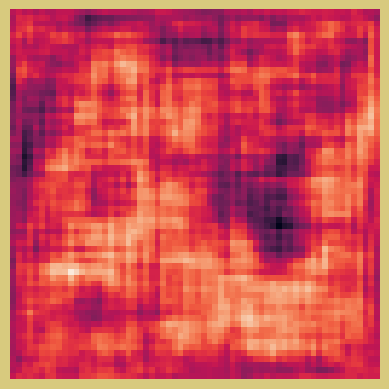

In [ ]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

Discriminator

In [ ]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 17, 17, 64)        256       
 chNormalization)                                     

In [ ]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.4996319]], shape=(1, 1), dtype=float32)


# **Training Process**

In [ ]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
#Defining the number of epochs
epochs = 200
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

generator.save('/content/drive/My Drive/my_generator_model.h5')

Epoch 1/200
65/65 [==============================] - 72s 942ms/step - d_loss: 0.6679 - g_loss: 0.7400
Epoch 2/200
65/65 [==============================] - 14s 194ms/step - d_loss: 0.6867 - g_loss: 0.7715
Epoch 3/200
65/65 [==============================] - 14s 193ms/step - d_loss: 0.6527 - g_loss: 0.8345
Epoch 4/200
65/65 [==============================] - 14s 193ms/step - d_loss: 0.6670 - g_loss: 0.8206
Epoch 5/200
65/65 [==============================] - 14s 193ms/step - d_loss: 0.6618 - g_loss: 0.8194
Epoch 6/200
65/65 [==============================] - 14s 194ms/step - d_loss: 0.6178 - g_loss: 0.9317
Epoch 7/200
65/65 [==============================] - 14s 193ms/step - d_loss: 0.5846 - g_loss: 1.0025
Epoch 8/200
65/65 [==============================] - 14s 193ms/step - d_loss: 0.5753 - g_loss: 1.0141
Epoch 9/200
65/65 [==============================] - 14s 193ms/step - d_loss: 0.5472 - g_loss: 1.0968
Epoch 10/200
65/65 [==============================] - 14s 194ms/step - d_loss: 0.5

Text(0.5, 1.0, 'Learning Curve')

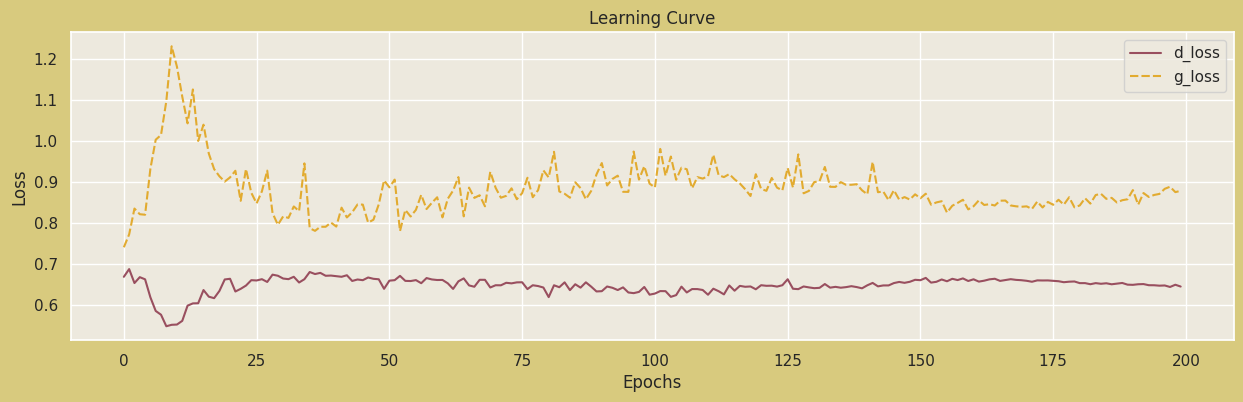

In [ ]:
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

# **Generate Images**

In [ ]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save('/content/drive/My Drive/generate/Portraits{:02d}.png'.format(i))
    return

#Generating images
Images = Potrait_Generator()

Found 18 files belonging to 1 classes.


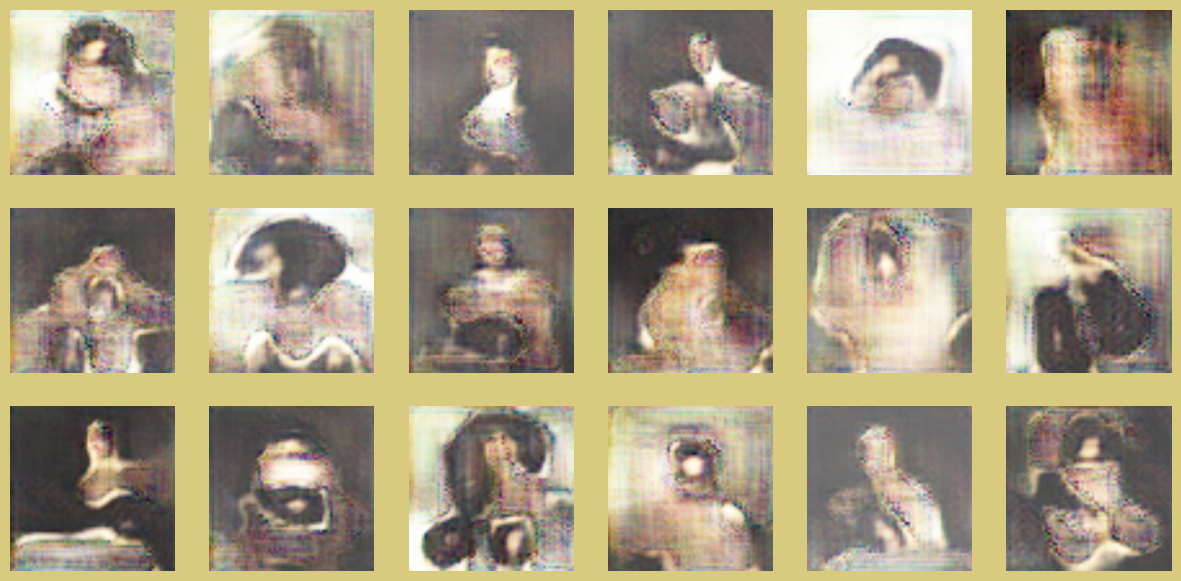

In [ ]:
#Loading generated images
Generated_path = "/content/drive/My Drive/generate/"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)